# Imports


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import random

from tqdm import tqdm
import pickle
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array,
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Activation,
    Dropout,
    Flatten,
    Dense,
    Input,
    Layer,
    RepeatVector,
)
from keras.optimizers import RMSprop
from tensorflow.keras.layers import (
    Embedding,
    LSTM,
    add,
    Concatenate,
    Reshape,
    concatenate,
    Bidirectional,
)
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, TimeDistributed, Concatenate, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import functional as F

plt.rcParams["font.size"] = 12
sns.set_style("dark")
warnings.filterwarnings("ignore")

# Dataset Loading


## TensorFlow GPU

In [ ]:
# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Optionally, set memory growth to prevent TensorFlow from allocating all GPU memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


## kaggle API

In [ ]:
import zipfile
import os

!!kaggle datasets download -d adityajn105/flickr8k

# Define the name of the directory to create
output_dir = 'flickr8k'

# Create the directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Unzip all files into the specified directory
with zipfile.ZipFile('flickr8k.zip', 'r') as zip_ref:
    zip_ref.extractall(output_dir)

In [ ]:
import zipfile
import os

!!kaggle datasets download -d abdoabdelmotlb/partitions

# Define the name of the directory to create
out_dir = 'partitions'

# Create the directory if it does not exist
os.makedirs(out_dir, exist_ok=True)

with zipfile.ZipFile('partitions.zip', 'r') as zip_ref:
    zip_ref.extractall(out_dir)

In [ ]:
import zipfile
import os


!!kaggle datasets download -d abdoabdelmotlb/output

# Define the name of the directory to create
out_dir = 'output'

# Create the directory if it does not exist
os.makedirs(out_dir, exist_ok=True)

with zipfile.ZipFile('output.zip', 'r') as zip_ref:
    zip_ref.extractall(out_dir)

## Declarations

In [ ]:
BASE_DIR = '/content'
OUTPUT_DIR = '/content/output'
captions_images_path = BASE_DIR + '/flickr8k/captions.txt'
images_path = BASE_DIR + '/flickr8k/Images'
train_images_names_path = BASE_DIR + '/partitions/Flickr_8k.trainImages.txt'
valid_images_names_path = BASE_DIR + '/partitions/Flickr_8k.devImages.txt'
test_images_names_path = BASE_DIR + '/partitions/Flickr_8k.testImages.txt'

## three partitions preparation

In [ ]:
# Load image names for the
def load_super_dataset(captions_images_path):
    return pd.read_csv(captions_images_path)[::5]

def load_image_names(file_path):
    with open(file_path, 'r') as file:
        return {line.strip() for line in file}

In [ ]:
import csv

def prepare_partitions_with_captions():
    # Initialize lists to hold the partitioned records
    train_records = []
    val_records = []
    test_records = []

    Dataset = load_super_dataset(captions_images_path)
    train_image_names_captions = load_image_names(train_images_names_path)
    val_image_names_captions = load_image_names(valid_images_names_path)
    test_image_names_captions = load_image_names(test_images_names_path)

    # partition the records
    train_records = Dataset[Dataset['image'].isin(train_image_names_captions)].values.tolist()
    val_records = Dataset[Dataset['image'].isin(val_image_names_captions)].values.tolist()
    test_records = Dataset[Dataset['image'].isin(test_image_names_captions)].values.tolist()

    return train_records, val_records, test_records


# CNN

## load images from dataset

In [ ]:
def read_image(image_name, img_size=224):
    image = load_img('/content/dog.jpg', target_size=(img_size, img_size))
    image = img_to_array(image)
    input_image = np.expand_dims(image, axis=0)
    img = preprocess_input(input_image)
    return img

## Load ResNet Model

In [ ]:
# load imagenet weights and remove the classification layer
base_model = ResNet50(weights='imagenet', include_top=False)

# Add a global average pooling layer to get the output shape (1, 1, 1, 2048)
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    tf.keras.layers.Reshape((1, 1, 2048)),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 2048)        0         
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 23534592 (89.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________

## Feature Extraction

In [ ]:
def feature_extraction(dataset):
    dataset = np.array(dataset)
    features = {}
    names = [row[0] for row in dataset]

    for image_name in names:
        image = read_image(image_name)
        feature = model.predict(image)
        image_id = image_name.split('.')[0]
        features[image_id] = feature

    return features

## Pickle Load and Store

In [ ]:
def save_features(features, output_path):
    output_path = OUTPUT_DIR + "/" + output_path
    with open(output_path, 'wb') as handle:
        pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Features saved to {output_path}")

In [ ]:
def load_features(features_path):
    features_path = OUTPUT_DIR + features_path
    with open(features_path, 'rb') as handle:
        features = pickle.load(handle)
    return features

## Store Extracted Features

In [ ]:
train_records, validation_records, test_records = prepare_partitions_with_captions()

In [ ]:
# on form { image_id, feature vector}
# train_extracted_feature = feature_extraction(train_records)
train_extracted_feature = load_features("/trainExtracted.pkl")

In [ ]:
# validation_records_extracted_feature = feature_extraction(validation_records)
validation_records_extracted_feature = load_features("/validationExtracted.pkl")
# validation_records_extracted_feature

In [ ]:
# test_extracted_feature = feature_extraction(test_records)
test_extracted_feature = load_features("/testExtracted.pkl")

In [ ]:
save_features(train_extracted_feature, "trainExtracted.pkl")

Features saved to /content/output/trainExtracted.pkl


In [ ]:
save_features(validation_records_extracted_feature, "validationExtracted.pkl")

Features saved to /content/output/validationExtracted.pkl


In [ ]:
save_features(test_extracted_feature, "testExtracted.pkl")

Features saved to /content/output/testExtracted.pkl


# RNN

## Preprocessing

### *Caption Cleaning*

In [ ]:
import re
def clean_text(captions):
    captions = [caption.lower() for caption in captions]
    captions = [re.sub("\s+", " ", caption.strip()) for caption in captions]
    captions = ["vipStartTkn " + caption + " vipEndTkn" for caption in captions]

    return captions

### *Text to number conversion*

In [ ]:
def preparing_tokens_matrix(dataset):
    '''
    i/p dataset: of type List(may be train, validation, test set).
    return: sequences after padding and truncating
    '''
    captions = [row[1] for row in dataset]
    captions = clean_text(captions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    sequences = tokenizer.texts_to_sequences(captions)
    vocab_size = len(tokenizer.word_index) + 1
    average_length = 20
    padded_sequences = pad_sequences(sequences, maxlen=average_length, padding='post', truncating='post')
    for seq in padded_sequences:
          if seq[-1] != 0:
                seq[-1] = tokenizer.texts_to_sequences(['vipEndTkn'])[0][0]
    return padded_sequences, vocab_size, average_length, tokenizer

## Building RNN

### Creating model

In [ ]:
def create_rnn_model(vocab_size, max_caption_length, image_shape, caption_shape, embedding_len=1024):
    MAX_LEN = max_caption_length

    # Model for image feature extraction
    img_model = Sequential()
    img_model.add(Dense(embedding_len,input_shape=(2048,),activation='relu'))
    img_model.add(RepeatVector(MAX_LEN))

    img_model.summary()

    # Model for generating captions from image features
    captions_model = Sequential()
    captions_model.add(Embedding(input_dim=vocab_size,output_dim=embedding_len,input_length=MAX_LEN))
    captions_model.add(LSTM(256,return_sequences=True))
    captions_model.add(TimeDistributed(Dense(embedding_len)))

    captions_model.summary()

    # Concatenating the outputs of image and caption models
    concat_output = Concatenate()([img_model.output,captions_model.output])
    # First LSTM Layer
    output = LSTM(units=128,return_sequences=True)(concat_output)
    # Second LSTM Layer
    output = LSTM(units=512,return_sequences=False)(output)
    # Output Layer
    output = Dense(units=vocab_size,activation='softmax')(output)
    # Creating the final model
    final_model = Model(inputs=[img_model.input,captions_model.input],outputs=output)
    # optimizer = RMSprop(learning_rate=0.001)

    final_model.compile(loss='categorical_crossentropy',optimizer="RMSprop",metrics='accuracy')
    final_model.summary()
    return final_model

### Train RNN

In [ ]:
def generate(images_dataset, captions_dataset, vocab_size):
  '''
  images_dataset.shape(6000, 2048)
  captions_dataset.shape(6000, 20 -> hp)
  '''
  caption_size = 20
  images = []
  captions_prefixes = []
  predicted_word_incoder = []
  for index, caption in enumerate(captions_dataset):
    for i in range(1,len(caption)):
      # if i != len(caption) - 1 and caption[i+1] == 0:
      #   continue
      prefixed_caption = [caption[:i]]
      padded_prefixed_caption = pad_sequences(prefixed_caption, maxlen=caption_size, padding='post')[0]
      next_predicted_word = caption[i]
      next_predicted_word = to_categorical([next_predicted_word], num_classes=vocab_size)[0]

      images.append(images_dataset[index])
      captions_prefixes.append(padded_prefixed_caption)
      predicted_word_incoder.append(next_predicted_word)
  return images, captions_prefixes, predicted_word_incoder

In [ ]:
def train_rnn(model, captions_dataset, images_dataset, vocab_size, num_epochs=10):
    images, captions_prefixes, predicted_word_incoder = generate(images_dataset[:], captions_dataset[:], vocab_size)
    model.fit([np.array(images), np.array(captions_prefixes)], np.array(predicted_word_incoder), batch_size=512, epochs=num_epochs)
    return model

## Test RNN

In [ ]:
images_dataset = []
ids = np.array([row[0] for row in train_records])

for id in ids:
    images_dataset.append(np.array(train_extracted_feature[id.split('.')[0]]))

images_dataset = np.array(images_dataset)
padded_sequences, vocab_size, average_length, tokenizer = preparing_tokens_matrix(train_records)

In [ ]:
model = create_rnn_model(vocab_size, average_length, images_dataset[0].shape, padded_sequences[0].shape)
images_dataset = images_dataset.reshape((6000,2048))
rnn_model = train_rnn(model, padded_sequences, images_dataset, vocab_size, 20)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 repeat_vector (RepeatVecto  (None, 20, 1024)          0         
 r)                                                              
                                                                 
Total params: 2098176 (8.00 MB)
Trainable params: 2098176 (8.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 1024)          3902464   
                                                                 
 lstm (LSTM)                 (None, 20, 256)           1311744

In [ ]:
def generate_caption(model, image, tokenizer, max_caption_length):
  start_token = tokenizer.texts_to_sequences(['vipStartTkn'])
  end_token = tokenizer.texts_to_sequences(['vipEndTkn'])


  caption = [start_token[0][0]] # token value
  for _ in range(max_caption_length - 1):
    # Prepare the input sequences for the model
    input_caption = tf.keras.preprocessing.sequence.pad_sequences([caption], maxlen=max_caption_length, padding='post',truncating='post')
    # Predict the next word
    predictions_input_image = image.reshape((1,2048))
    predictions = model.predict([np.array(predictions_input_image), np.array(input_caption)])
    predicted_id = np.argmax(predictions)

    # Append the predicted word to the caption
    caption.append(predicted_id)

    # Break if end token is generated
    if predicted_id == end_token[0][0]:
        break

  # Convert the generated word IDs back to words
  generated_caption = tokenizer.sequences_to_texts([caption])[0]

  return generated_caption

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def display_image(image_path):
    """
    This function takes the path of an image file, opens it,
    and displays it using matplotlib.

    Parameters:
    image_path (str): The path to the image file.
    """
    try:
        # Open the image file
        img = Image.open(images_path + "/" + image_path)

        # Display the image
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        plt.show()

    except FileNotFoundError:
        print(f"The file at {image_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

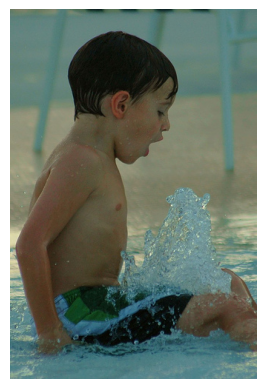

1/1 [==============================] - 0s 66ms/step
caption:  vipstarttkn a girl in a swimsuit is playing in a pool vipendtkn


In [ ]:
image_name = "1287475186_2dee85f1a5.jpg"
display_image(image_name)

# feature_vector = train_extracted_feature["2288315705_5f4c37d932"]
feature_vector = test_extracted_feature["1287475186_2dee85f1a5"]

caption = generate_caption(rnn_model, feature_vector, tokenizer, average_length)
print("caption: ", caption)

## getting validation loss and accuracy

In [ ]:
val_images_dataset = []
ids = np.array([row[0] for row in validation_records])

for id in ids:
    val_images_dataset.append(np.array(validation_records_extracted_feature[id.split('.')[0]]))

val_images_dataset = np.array(val_images_dataset)
padded_sequences, vocab_size, average_length, tokenizer = preparing_tokens_matrix(validation_records)

In [ ]:
val_images, val_captions_prefixes, val_predicted_word_incoder = generate(val_images_dataset[:], padded_sequences[:], vocab_size)
val_images = np.array(val_images).reshape(-1, 2048)

val_loss, val_accuracy = model.evaluate(
    [np.array(val_images), np.array(val_captions_prefixes)],
    np.array(val_predicted_word_incoder),
    batch_size=512
)



# Blue score

In [ ]:
def plot_images(scores, dataset):

  indexed_list = list(enumerate(scores))
  sorted_indexed_list = sorted(indexed_list, key=lambda x: x[1])
  sorted_indices = [index for index, value in sorted_indexed_list]

  # print the smallest two scores
  for i in range(3):
    image_name = dataset[sorted_indices[0]]
    score = scores[sorted_indices[0]]
    print("Images with low bleu score:")
    print(f"image id = {image_name}, with bleu score = {score}")
    display_image(image_name)

  # print the highest two scores
  for i in range(len(dataset) - 1, len(dataset) - 3, -1):
    image_name = dataset[sorted_indices[0]]
    score = scores[sorted_indices[0]]
    print("Images with low bleu score:")
    print(f"image id = {image_name}, with bleu score = {score}")
    display_image(image_name)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from concurrent.futures import ThreadPoolExecutor, as_completed
import concurrent.futures

def process_image_caption(image_name, caption, image_features, rnn_model, tokenizer, average_length):
    image_id = image_name.split('.')[0]
    feature_vector = image_features[image_id]
    caption = caption.split(" ")

    predicted_caption = generate_caption(rnn_model, feature_vector, tokenizer, average_length)
    predicted_caption = predicted_caption.split(" ")[1:]
    if predicted_caption[-1] == "vipStartTkn":
        predicted_caption.pop()

    return (caption, predicted_caption)

def dataset_captions_predictions(dataset, image_features, rnn_model, tokenizer, average_length):
    references = []
    candidates = []

    with ThreadPoolExecutor() as executor:
        future_to_image = {
            executor.submit(process_image_caption, image_name, caption, image_features, rnn_model, tokenizer, average_length): (image_name, caption)
            for image_name, caption in dataset
        }

        for i, future in enumerate(as_completed(future_to_image), start=1):
            image_name, caption = future_to_image[future]
            try:
                caption, predicted_caption = future.result()
                print(f"Image number: {image_name}")
                print("real:", caption)
                print("predicted:", predicted_caption)

                references.append([caption])
                candidates.append(predicted_caption)
            except Exception as exc:
                print(f"{image_name} generated an exception: {exc}")

    corpus_bleu_score = corpus_bleu(references, candidates, weights=(1.0, 0, 0, 0))
    print(corpus_bleu_score)

In [ ]:
dataset_captions_predictions(test_records[:30], test_extracted_feature, rnn_model, tokenizer, average_length)

1/1 [==============================] - 0s 78ms/step
Image number: 1084040636_97d9633581.jpg
real: ['A', 'closeup', 'of', 'a', 'white', 'dog', 'that', 'is', 'laying', 'its', 'head', 'on', 'its', 'paws', '.']
predicted: ['a', 'black', 'dog', 'is', 'walking', 'on', 'a', 'beach', 'vipendtkn']
1/1 [==============================] - 0s 69ms/step
Image number: 1107246521_d16a476380.jpg
real: ['a', 'black', 'dog', 'jumping', 'to', 'catch', 'a', 'rope', 'toy']
predicted: ['a', 'black', 'dog', 'is', 'running', 'on', 'a', 'grassy', 'field', 'vipendtkn']
1/1 [==============================] - 0s 51ms/step
Image number: 1082379191_ec1e53f996.jpg
real: ['A', 'lady', 'and', 'a', 'man', 'with', 'no', 'shirt', 'sit', 'on', 'a', 'dock', '.']
predicted: ['a', 'man', 'in', 'a', 'yellow', 'shirt', 'is', 'sitting', 'on', 'a', 'bench', 'vipendtkn']
1/1 [==============================] - 0s 64ms/step
Image number: 106490881_5a2dd9b7bd.jpg
real: ['A', 'boy', 'in', 'his', 'blue', 'swim', 'shorts', 'at', 'the', 

# Draft



## LOAD TIME TESTING

In [ ]:
train_records, val_records, test_records = prepare_partitions_with_captions()
print(np.array(train_records).shape)
print(np.array(val_records).shape)
print(np.array(test_records).shape)
train_records[0:2]

(6000, 2)
(1000, 2)
(1000, 2)


[['1000268201_693b08cb0e.jpg',
  'A child in a pink dress is climbing up a set of stairs in an entry way .'],
 ['1001773457_577c3a7d70.jpg', 'A black dog and a spotted dog are fighting']]

## Test CNN

In [ ]:
img = read_image("1000268201_693b08cb0e.jpg")
print(np.array(img).shape)

(1, 224, 224, 3)


In [ ]:
first_column = [row[0] for row in train_records]
first_column

In [ ]:
dic = feature_extraction(train_records)

In [ ]:
def test_generate():
    # Mock data
    images_dataset = np.random.rand(5, 2048)  # 5 images with 2048 features each
    captions_dataset = np.array([
        [1, 2, 3, 0, 0],  # caption for the first image
        [4, 5, 6, 7, 0],  # caption for the second image
        [8, 9, 10, 11, 12],  # caption for the third image
        [13, 14, 15, 0, 0],  # caption for the fourth image
        [16, 17, 18, 19, 20]  # caption for the fifth image
    ])
    vocab_size = 21  # Considering 0 to 20 as words in the vocabulary

    # Expected output shapes
    expected_images_shape = (13, 2048)  # Sum of lengths of non-zero sequences in captions - 1
    expected_captions_prefixes_shape = (13, 5)  # Caption size (5) for each prefix
    expected_predicted_word_incoder_shape = (13, vocab_size)  # One-hot encoded next word

    # Run the function
    images, captions_prefixes, predicted_word_incoder = generate(images_dataset, captions_dataset, vocab_size)
    print(np.array(images).shape, np.array(captions_prefixes).shape, np.array(predicted_word_incoder).shape)
test_generate()

(5, 2048) (5, 5)
[4 5 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(15, 2048) (15, 20) (15, 21)


In [ ]:
tokenizer.texts_to_sequences(['dog'])

[[9]]

# image-testing

In [ ]:
alpha = [0.01,0.001]
epochs = [20,40]


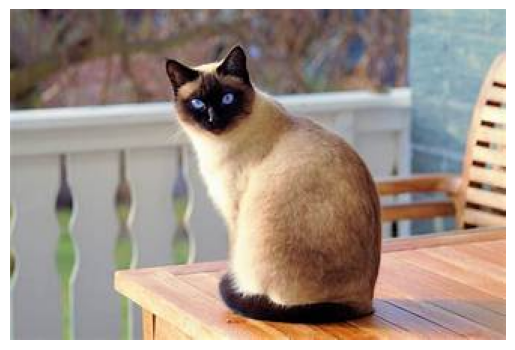

In [ ]:
 # Open the image file
img = Image.open('/content/cat.jpg')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

# internet

In [ ]:

dataset = [["cat.jpg", "brown cat with black eyes on a chair"]]
features = feature_extraction(dataset)



1/1 [==============================] - 0s 24ms/step


{'cat': array([[[[0.14291514, 0.07911512, 0.00220117, ..., 0.46251398,
           0.3934714 , 0.08239789]]]], dtype=float32)}

In [ ]:
dataset_captions_predictions(dataset, features, rnn_model, tokenizer, average_length)

1/1 [==============================] - 0s 39ms/step
Image number: cat.jpg
real: ['brown', 'cat', 'with', 'black', 'eyes', 'on', 'a', 'chair']
predicted: ['a', 'brown', 'dog', 'is', 'laying', 'on', 'a', 'fence', 'vipendtkn']
0.3333333333333333


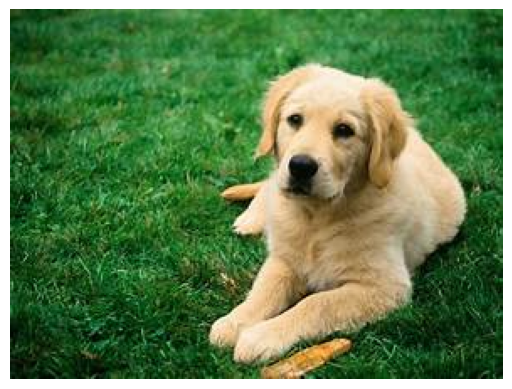

In [ ]:
 # Open the image file
img = Image.open('/content/dog.jpg')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
dataset = [["dog.jpg", "A brown dog playing with a toy on a grass"]]
features = feature_extraction(dataset)
features

1/1 [==============================] - 0s 35ms/step


{'dog': array([[[[0.19403997, 0.        , 0.20715648, ..., 0.26345   ,
           0.07400896, 0.12224694]]]], dtype=float32)}

In [ ]:
dataset_captions_predictions(dataset, features, rnn_model, tokenizer, average_length)

1/1 [==============================] - 0s 19ms/step
Image number: dog.jpg
real: ['A', 'brown', 'dog', 'playing', 'with', 'a', 'toy', 'on', 'a', 'grass']
predicted: ['a', 'brown', 'dog', 'is', 'playing', 'with', 'a', 'toy', 'vipendtkn']
0.6959861353000654
